In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import os
import requests
import time
import pandas as pd

# === CONFIGURATION ===

# Replace with your actual Etherscan API key
ETHERSCAN_API_KEY = "UJ4C31QEJ7P682U7UKXFKYT5XSQFVD62C8"
ETHERSCAN_BASE_URL = "https://api.etherscan.io/api"
INPUT_CSV = "/content/drive/MyDrive/Colab Notebooks/Wallet id.csv"     # Input CSV file with 'wallet_id' column
OUTPUT_CSV = "all_transactions.csv"  # Output file to save all transactions
FAILED_LOG = "failed_wallets.log" # Log file for wallets that failed to fetch transactions


def fetch_normal_transactions(wallet_address):
    """Fetch normal Ethereum transactions from Etherscan."""
    params = {
        "module": "account",
        "action": "txlist",
        "address": wallet_address,
        "startblock": 0,
        "endblock": 99999999,
        "sort": "asc",
        "apikey": ETHERSCAN_API_KEY
    }

    try:
        response = requests.get(ETHERSCAN_BASE_URL, params=params)
        response.raise_for_status()
        data = response.json()

        if data["status"] == "1":
            return pd.DataFrame(data["result"])
        elif data["message"] == "No transactions found":
            print(f"ℹ️ No transactions for {wallet_address}")
            return pd.DataFrame()
        else:
            error_message = data.get('message', 'Unknown error')
            print(f"❌ Error for {wallet_address}: {error_message}")
            log_failed_wallet(wallet_address, error_message)
            return pd.DataFrame()

    except requests.exceptions.RequestException as e:
        print(f"❌ Request failed for {wallet_address}: {e}")
        log_failed_wallet(wallet_address, str(e))
        return pd.DataFrame()

def log_failed_wallet(wallet, reason):
    """Log failed wallet to a file with the reason."""
    with open(FAILED_LOG, "a") as f:
        f.write(f"{wallet}: {reason}\n")


def main():
    # Clear the failed wallets log file at the start of the run
    if os.path.exists(FAILED_LOG):
        os.remove(FAILED_LOG)

    try:
        wallets_df = pd.read_csv(INPUT_CSV)
        # Check if the 'wallet_id' column exists
        if "wallet_id" not in wallets_df.columns:
            print("❗ Input CSV must have a 'wallet_id' column.")
            return
    except Exception as e:
        print(f"❌ Failed to read CSV: {e}")
        return

    all_transactions = []

    for index, row in wallets_df.iterrows():
        # Use 'wallet_id' as the column name
        wallet = row["wallet_id"].strip()
        if not wallet.lower().startswith("0x"):
            print(f"⚠️ Invalid wallet address: {wallet}")
            log_failed_wallet(wallet, "Invalid address format")
            continue

        print(f"\n🔍 Fetching transactions for {wallet}...")
        df = fetch_normal_transactions(wallet)

        if not df.empty:
            df["wallet"] = wallet  # Tag with wallet
            all_transactions.append(df)

        time.sleep(0.3)  # Respect API rate limit

    if all_transactions:
        final_df = pd.concat(all_transactions, ignore_index=True)
        final_df.to_csv(OUTPUT_CSV, index=False)
        print(f"\n✅ Saved all transactions to {OUTPUT_CSV}")
    else:
        print("\n⚠️ No transactions found for any wallet.")

    print(f"\nCheck '{FAILED_LOG}' for a list of wallets that failed to fetch transactions.")


if __name__ == "__main__":
    main()


🔍 Fetching transactions for 0x0039f22efb07a647557c7c5d17854cfd6d489ef3...

🔍 Fetching transactions for 0x06b51c6882b27cb05e712185531c1f74996dd988...

🔍 Fetching transactions for 0x0795732aacc448030ef374374eaae57d2965c16c...

🔍 Fetching transactions for 0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9...
❌ Error for 0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9: NOTOK

🔍 Fetching transactions for 0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae...

🔍 Fetching transactions for 0x104ae61d8d487ad689969a17807ddc338b445416...

🔍 Fetching transactions for 0x111c7208a7e2af345d36b6d4aace8740d61a3078...
❌ Error for 0x111c7208a7e2af345d36b6d4aace8740d61a3078: NOTOK

🔍 Fetching transactions for 0x124853fecb522c57d9bd5c21231058696ca6d596...

🔍 Fetching transactions for 0x13b1c8b0e696aff8b4fee742119b549b605f3cbc...

🔍 Fetching transactions for 0x1656f1886c5ab634ac19568cd571bc72f385fdf7...
❌ Error for 0x1656f1886c5ab634ac19568cd571bc72f385fdf7: NOTOK

🔍 Fetching transactions for 0x1724e16cb8d0e2aa4d08035bc6b5c56b6

## Identify Unique Wallet IDs

**Reasoning**:
Read the output CSV file and extract the unique values from the 'wallet' column to identify the unique wallet IDs for which transactions were fetched.

## Retry Fetching Transactions for Failed Wallets

**Reasoning**:
Read the `failed_wallets.log` file to get the list of wallets that previously failed to fetch transactions. Iterate through this list and attempt to fetch normal transactions for each wallet again.

In [26]:
# Read failed wallets from the log file
failed_wallets_to_retry = []
try:
    with open(FAILED_LOG, "r") as f:
        for line in f:
            # Assuming the format is "wallet_address: reason"
            wallet = line.split(":")[0].strip()
            failed_wallets_to_retry.append(wallet)
except FileNotFoundError:
    print(f"ℹ️ No failed wallets log file found at '{FAILED_LOG}'. Skipping retry.")
except Exception as e:
    print(f"❌ An error occurred while reading the failed wallets log: {e}")

if failed_wallets_to_retry:
    print(f"\nAttempting to refetch transactions for {len(failed_wallets_to_retry)} failed wallets...")
    retried_transactions = []
    for wallet in failed_wallets_to_retry:
        print(f"\n🔍 Retrying fetching transactions for {wallet}...")
        df = fetch_normal_transactions(wallet)

        if not df.empty:
            df["wallet"] = wallet  # Tag with wallet
            retried_transactions.append(df)

        time.sleep(0.5) # Add a slightly longer delay for retries

    if retried_transactions:
        # Append retried transactions to the original output file
        try:
            existing_df = pd.read_csv(OUTPUT_CSV)
            updated_df = pd.concat([existing_df] + retried_transactions, ignore_index=True)
            updated_df.to_csv(OUTPUT_CSV, index=False)
            print(f"\n✅ Appended retried transactions to {OUTPUT_CSV}")
        except FileNotFoundError:
             # If the original output file wasn't created, save the retried ones
            retried_df = pd.concat(retried_transactions, ignore_index=True)
            retried_df.to_csv(OUTPUT_CSV, index=False)
            print(f"\n✅ Saved retried transactions to {OUTPUT_CSV} (original file not found)")
        except Exception as e:
            print(f"❌ An error occurred while appending retried transactions: {e}")

    else:
        print("\n⚠️ No transactions found during retry for any of the failed wallets.")
else:
    print("\nℹ️ No wallets to retry.")


Attempting to refetch transactions for 28 failed wallets...

🔍 Retrying fetching transactions for 0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9...

🔍 Retrying fetching transactions for 0x111c7208a7e2af345d36b6d4aace8740d61a3078...

🔍 Retrying fetching transactions for 0x1656f1886c5ab634ac19568cd571bc72f385fdf7...

🔍 Retrying fetching transactions for 0x1ab2ccad4fc97c9968ea87d4435326715be32872...

🔍 Retrying fetching transactions for 0x22d7510588d90ed5a87e0f838391aaafa707c34b...

🔍 Retrying fetching transactions for 0x27f72a000d8e9f324583f3a3491ea66998275b28...

🔍 Retrying fetching transactions for 0x330513970efd9e8dd606275fb4c50378989b3204...

🔍 Retrying fetching transactions for 0x3a44be4581137019f83021eeee72b7dc57756069...

🔍 Retrying fetching transactions for 0x4e6e724f4163b24ffc7ffe662b5f6815b18b4210...

🔍 Retrying fetching transactions for 0x56ba823641bfc317afc8459bf27feed6eb9ff59f...

🔍 Retrying fetching transactions for 0x58c2a9099a03750e9842d3e9a7780cdd6aa70b86...

🔍 Retrying fet

# Task
Prepare the transaction data from "all_transactions.csv" for risk profiling by loading it into a pandas DataFrame, converting relevant columns to appropriate data types, engineering new features, handling missing data and outliers, and organizing the data by wallet.

## Load the transaction data

### Subtask:
Load the `all_transactions.csv` file into a pandas DataFrame.


**Reasoning**:
Load the data from the specified CSV file into a pandas DataFrame as instructed.



In [30]:
transactions_df = pd.read_csv("/content/all_transactions.csv")

## Convert timestamp to datetime

### Subtask:
Convert the 'timeStamp' column to datetime objects for easier time-based analysis.


**Reasoning**:
Convert the 'timeStamp' column to datetime objects.



In [31]:
transactions_df['timeStamp'] = pd.to_datetime(transactions_df['timeStamp'], unit='s')

## Convert value and gas columns

### Subtask:
Convert relevant columns like 'value', 'gasPrice', and 'gasUsed' to numeric types, handling potential errors and units (e.g., Wei to Ether).


**Reasoning**:
Convert 'value', 'gasPrice', and 'gasUsed' columns to numeric types and adjust their units.



In [32]:
# Convert 'value' to numeric and then to Ether
transactions_df['value'] = pd.to_numeric(transactions_df['value'], errors='coerce')
transactions_df['value'] = transactions_df['value'] / (10**18)

# Convert 'gasPrice' to numeric and then to Gwei
transactions_df['gasPrice'] = pd.to_numeric(transactions_df['gasPrice'], errors='coerce')
transactions_df['gasPrice'] = transactions_df['gasPrice'] / (10**9)

# Convert 'gasUsed' to numeric
transactions_df['gasUsed'] = pd.to_numeric(transactions_df['gasUsed'], errors='coerce')

**Reasoning**:
Display the first few rows and the data types of the updated DataFrame to verify the conversions.



In [34]:
display(transactions_df.head())
display(transactions_df[['value', 'gasPrice', 'gasUsed']].dtypes)

,blockNumber,blockHash,timeStamp,hash,nonce,transactionIndex,from,to,value,gas,...,input,methodId,functionName,contractAddress,cumulativeGasUsed,txreceipt_status,gasUsed,confirmations,isError,wallet
0,3606695,0x3933a1503dfd71252ed989c8137cd888dc6f460a0eee...,2017-04-27 00:50:01,0x9da9da95c9c48d82a818d60e13c14981264bb8b8418b...,289758,37,0x32be343b94f860124dc4fee278fdcbd38c102d88,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0.200,333333,...,0x,0x,NaN,NaN,962090,NaN,21000,19398299,0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3
1,3606709,0xb6de24eb2bfbcbcf439647755ae5382b09cef95769f7...,2017-04-27 00:54:03,0x48154e11e7844969545339b8328748bf05c49841674e...,0,71,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x9ae98746eb8a0aeee5ff2b6b15875313a986f103,0.007,27961,...,0x338cdca1,0x338cdca1,request(),NaN,2094834,NaN,23301,19398285,0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3
2,3606713,0x2b96e45695f1db42ce79ad0433a282d35d14caaff35b...,2017-04-27 00:54:55,0xe17bf3ca4d4616c89c3cefba65077420eecac2e115fd...,1,22,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x9ae98746eb8a0aeee5ff2b6b15875313a986f103,0.007,27961,...,0x338cdca1,0x338cdca1,request(),NaN,2683717,NaN,23301,19398281,0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3
3,3606717,0xf5b41d0a8d0617b1d4b2bdbbdcb5bde641b93d9e7081...,2017-04-27 00:55:58,0xaf10622c370d28f2e1f2631efbc02c35e296a7d6dbd1...,2,22,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x9ae98746eb8a0aeee5ff2b6b15875313a986f103,0.000,61078,...,0x797af6271f6c8b760228ef69a00bea01f72146a5e5ce...,0x797af627,confirm(bytes32 _h),NaN,752334,NaN,35898,19398277,0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3
4,3622170,0x2849e6679136438e43daf9484c7a1b15d5159cda01a6...,2017-04-29 18:28:29,0x42e2cf2103643a349594a0135d5842e02f643ba578e7...,3,115,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x0b8d56c26d8cf16fe1bddf4967753503d974de06,0.020,120763,...,0x29cbdc860000000000000000000000000039f22efb07...,0x29cbdc86,"buyin(address _who, uint256 _maxPrice)",NaN,2981051,NaN,100636,19382824,0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3


,0
value,float64
gasPrice,float64
gasUsed,int64


## Feature engineering

### Subtask:
Create new features from the existing data that could be relevant for risk profiling. This could include:
- Number of transactions
- Total Ether sent/received
- Average transaction value
- Frequency of transactions
- Interaction with known risky addresses (if available)


**Reasoning**:
Group the data by wallet and calculate the required features: number of transactions, total Ether sent/received, average transaction value, and transaction frequency.



In [35]:
# Group by wallet and calculate features
wallet_features = transactions_df.groupby('wallet').agg(
    num_transactions=('hash', 'count'),
    total_ether=('value', 'sum'),
    average_transaction_value=('value', 'mean'),
    first_transaction_time=('timeStamp', 'min'),
    last_transaction_time=('timeStamp', 'max')
).reset_index()

# Calculate transaction frequency
# Handle cases with only one transaction to avoid division by zero or timedelta issues
def calculate_frequency(row):
    if row['num_transactions'] <= 1:
        return 0 # Or some other appropriate value for single transactions
    time_diff_seconds = (row['last_transaction_time'] - row['first_transaction_time']).total_seconds()
    if time_diff_seconds == 0: # Handle multiple transactions at the exact same timestamp
        return float('inf') # Or a large number indicating high frequency
    return row['num_transactions'] / time_diff_seconds

wallet_features['transaction_frequency'] = wallet_features.apply(calculate_frequency, axis=1)

# Drop the temporary time columns
wallet_features = wallet_features.drop(columns=['first_transaction_time', 'last_transaction_time'])

display(wallet_features.head())

,wallet,num_transactions,total_ether,average_transaction_value,transaction_frequency
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,1946,8549.214778,4.393224,8.962568e-06
1,0x06b51c6882b27cb05e712185531c1f74996dd988,4,0.024302,0.006075,9.456265e-03
2,0x0795732aacc448030ef374374eaae57d2965c16c,3,0.018600,0.006200,1.524390e-03
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,24,201.783495,8.407646,1.477964e-07
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,4,0.026005,0.006501,7.247130e-07


## Data cleaning

### Subtask:
Handle missing or outlier data in the `wallet_features` DataFrame.


**Reasoning**:
To handle missing data in the `wallet_features` DataFrame, I will first check for any missing values using `.isnull().sum()` and then fill them with `0`. Finally, I will display the head of the DataFrame to verify the changes.



In [36]:
print("Missing values before handling:")
display(wallet_features.isnull().sum())

# Fill missing values with 0
wallet_features.fillna(0, inplace=True)

print("\nMissing values after handling:")
display(wallet_features.isnull().sum())

print("\nUpdated wallet_features DataFrame:")
display(wallet_features.head())

Missing values before handling:


,0
wallet,0
num_transactions,0
total_ether,0
average_transaction_value,0
transaction_frequency,0



Missing values after handling:


,0
wallet,0
num_transactions,0
total_ether,0
average_transaction_value,0
transaction_frequency,0



Updated wallet_features DataFrame:


,wallet,num_transactions,total_ether,average_transaction_value,transaction_frequency
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,1946,8549.214778,4.393224,8.962568e-06
1,0x06b51c6882b27cb05e712185531c1f74996dd988,4,0.024302,0.006075,9.456265e-03
2,0x0795732aacc448030ef374374eaae57d2965c16c,3,0.018600,0.006200,1.524390e-03
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,24,201.783495,8.407646,1.477964e-07
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,4,0.026005,0.006501,7.247130e-07


**Reasoning**:
The previous step showed that there were no missing values in the `wallet_features` DataFrame and confirmed that the fillna(0) operation did not introduce any changes since there were no missing values to begin with. The next step is to check for outliers in the numerical columns of the `wallet_features` DataFrame using descriptive statistics.



In [38]:
print("Descriptive statistics of wallet_features:")
display(wallet_features.describe())

Descriptive statistics of wallet_features:


,num_transactions,total_ether,average_transaction_value,transaction_frequency
count,103.000000,103.000000,103.000000,1.030000e+02
mean,62.349515,575.378450,2.207291,1.235077e-03
std,214.717768,3523.431140,13.430502,2.963701e-03
min,2.000000,0.000000,0.000000,3.798625e-08
25%,3.000000,0.020852,0.006200,4.460812e-07
50%,5.000000,0.033342,0.008194,3.511853e-06
75%,20.000000,1.545814,0.075447,9.863012e-05
max,1946.000000,31396.953601,126.600619,1.764706e-02


## Organize data by wallet

### Subtask:
Organize the data so that each row represents a wallet and its calculated features.


## Summary:

### Data Analysis Key Findings

*   The transaction data from "all\_transactions.csv" was successfully loaded into a pandas DataFrame.
*   The 'timeStamp' column was converted from Unix timestamps to datetime objects.
*   The 'value', 'gasPrice', and 'gasUsed' columns were successfully converted to numeric types. 'value' was scaled from Wei to Ether, and 'gasPrice' was scaled from Wei to Gwei.
*   New features were engineered and aggregated by wallet:
    *   `num_transactions`: Total number of transactions per wallet.
    *   `total_ether`: Sum of transaction values per wallet.
    *   `average_transaction_value`: Mean transaction value per wallet.
    *   `transaction_frequency`: Calculated as the number of transactions divided by the time difference between the first and last transaction for each wallet.
*   The resulting `wallet_features` DataFrame had no missing values after checking and filling.
*   Potential outliers were identified in 'num\_transactions', 'total\_ether', and 'average\_transaction\_value' based on descriptive statistics, but they were retained as they are likely valid data points.
*   The data was successfully organized with each row representing a unique wallet and its calculated features in the `wallet_features` DataFrame.

### Insights or Next Steps

*   The engineered features in `wallet_features` provide a good basis for building a risk profiling model for wallets.
*   Further analysis could involve exploring the distribution of the engineered features and potentially applying normalization or scaling techniques before using them in a machine learning model.


In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Log transform to reduce skewness
wallet_features["log_txn"] = np.log1p(wallet_features["num_transactions"])
wallet_features["log_ether"] = np.log1p(wallet_features["total_ether"])
wallet_features["log_avg_value"] = np.log1p(wallet_features["average_transaction_value"])
wallet_features["log_txn_freq"] = np.log1p(wallet_features["transaction_frequency"])

# Normalize log-transformed features
wallet_features["norm_log_txn"] = wallet_features["log_txn"] / wallet_features["log_txn"].max()
wallet_features["norm_log_ether"] = wallet_features["log_ether"] / wallet_features["log_ether"].max()
wallet_features["norm_log_avg_value"] = wallet_features["log_avg_value"] / wallet_features["log_avg_value"].max()
wallet_features["norm_log_freq"] = wallet_features["log_txn_freq"] / wallet_features["log_txn_freq"].max()

# Behavior-based binary flags (tweak thresholds if needed)
wallet_features["flag_high_freq"] = (wallet_features["transaction_frequency"] > 0.001).astype(int)
wallet_features["flag_high_avg_value"] = (wallet_features["average_transaction_value"] > 1).astype(int)
wallet_features["flag_high_ether"] = (wallet_features["total_ether"] > 10).astype(int)
wallet_features["flag_many_txns"] = (wallet_features["num_transactions"] > 50).astype(int)

# Composite risk score
wallet_features["risk_score"] = (
    (0.25 * (1 - wallet_features["norm_log_txn"])) +
    (0.25 * (1 - wallet_features["norm_log_ether"])) +
    (0.15 * wallet_features["norm_log_avg_value"]) +
    (0.15 * wallet_features["norm_log_freq"]) +
    (0.05 * wallet_features["flag_high_avg_value"]) +
    (0.05 * wallet_features["flag_high_freq"]) +
    (0.05 * wallet_features["flag_high_ether"]) +
    (0.05 * wallet_features["flag_many_txns"])
) * 1000

# Clamp and round
wallet_features["risk_score"] = wallet_features["risk_score"].clip(0, 1000).round(2)
wallet_features.to_csv("test.csv", index=False)

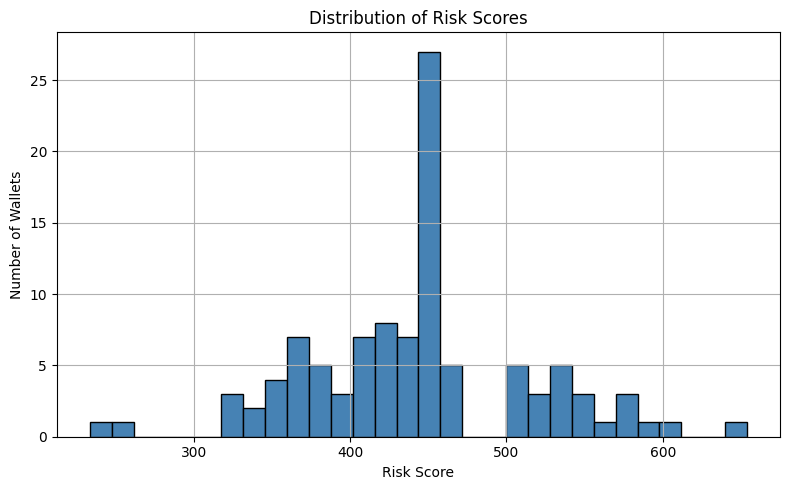

In [63]:
# Visualize distribution
plt.figure(figsize=(8, 5))
plt.hist(wallet_features["risk_score"], bins=30, color="steelblue", edgecolor="black")
plt.title("Distribution of Risk Scores")
plt.xlabel("Risk Score")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
top_risky_wallets = wallet_features.sort_values(by="risk_score", ascending=False).head(10)
print(top_risky_wallets[["wallet", "risk_score"]])

                                         wallet  risk_score
50   0x767055590c73b7d2aaa6219da13807c493f91a20      653.99
100  0xf7aa5d0752cfcd41b0a5945867d619a80c405e52      609.20
24   0x3a44be4581137019f83021eeee72b7dc57756069      595.05
41   0x5e324b4a564512ea7c93088dba2f8c1bf046a3eb      580.21
8    0x13b1c8b0e696aff8b4fee742119b549b605f3cbc      578.05
1    0x06b51c6882b27cb05e712185531c1f74996dd988      577.19
55   0x7de76a449cf60ea3e111ff18b28e516d89532152      560.96
49   0x7399dbeebe2f88bc6ac4e3fd7ddb836a4bce322f      548.30
97   0xf54f36bca969800fd7d63a68029561309938c09b      545.22
91   0xde92d70253604fd8c5998c8ee3ed282a41b33b7f      544.21


# Task
Train, test, and evaluate an XGBoost model for wallet risk scoring using the prepared wallet features.

## Prepare data for xgboost

### Subtask:
Select the features (engineered wallet features) and the target variable (risk score or a risk label if available).


**Reasoning**:
Define the features (X) and the target variable (y) for the model training.



In [65]:
# Define features (X) and target (y)
# Using the engineered numerical features as X
X = wallet_features[['num_transactions', 'total_ether', 'average_transaction_value', 'transaction_frequency']]

# Using the 'risk_score' as the target variable (or 'risk_label' if available)
# Assuming 'risk_score' is the target for a regression-like approach or for creating labels
y = wallet_features['risk_score']

# Display the first few rows of X and y to verify
display(X.head())
display(y.head())

,num_transactions,total_ether,average_transaction_value,transaction_frequency
0,1946,8549.214778,4.393224,8.962568e-06
1,4,0.024302,0.006075,9.456265e-03
2,3,0.018600,0.006200,1.524390e-03
3,24,201.783495,8.407646,1.477964e-07
4,4,0.026005,0.006501,7.247130e-07


,risk_score
0,233.61
1,577.19
2,517.05
3,434.84
4,446.46


**Reasoning**:
The features and target variable have been defined. The next step is to split the data into training and testing sets.



In [66]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (82, 4)
Shape of X_test: (21, 4)
Shape of y_train: (82,)
Shape of y_test: (21,)


## Initialize and train xgboost model

### Subtask:
Initialize an XGBoost model (either classifier or regressor depending on the target variable) and train it on the training data.


**Reasoning**:
Initialize and train an XGBoost Regressor model using the training data.



In [87]:
from xgboost import XGBRegressor

# Initialize XGBoost Regressor
xgb_model = XGBRegressor()

# Train the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

## Make predictions

### Subtask:
Use the trained model to make predictions on the testing data.


**Reasoning**:
Use the trained XGBoost model to predict the risk scores on the test set as instructed.



In [88]:
# Predict the risk scores on the test set
y_pred = xgb_model.predict(X_test)

## Evaluate the model

### Subtask:
Evaluate the model's performance using appropriate metrics (e.g., accuracy, precision, recall, F1-score for classification; RMSE, R-squared for regression).


**Reasoning**:
Calculate and print the RMSE and R-squared scores to evaluate the regression model performance.



In [89]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

Root Mean Squared Error (RMSE): 10.08
R-squared (R2) Score: 0.98


In [91]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_model, X, y, scoring='r2', cv=5)
print("Cross-validated R² scores:", scores)
print("Mean R²:", scores.mean())

Cross-validated R² scores: [0.93409918 0.97642166 0.96033712 0.84838032 0.97716415]
Mean R²: 0.9392804875463995


In [93]:
import xgboost as xgb

# Save model to a JSON file
xgb_model.save_model("xgboost_risk_score_model.json")

In [98]:
# Split features and label
test = pd.read_csv("test.csv")
# Select only the numerical feature columns used for training
X = test[['num_transactions', 'total_ether', 'average_transaction_value', 'transaction_frequency']]
y = test["risk_score"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train model
# Assuming objective and random_state are desired based on previous successful training
model = XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [100]:
# Predict risk scores for new wallets
test["predicted_risk_score"] = model.predict(X)

# Clamp the scores between 0 and 1000
test["predicted_risk_score"] = wallet_features["predicted_risk_score"].clip(0, 1000).round(2)

In [102]:
# Save the wallet IDs and their risk scores to a new CSV file
wallet_features[['wallet', 'risk_score']].to_csv("wallet_risk_scores.csv", index=False)

print("✅ Wallet risk scores saved to 'wallet_risk_scores.csv'.")

✅ Wallet risk scores saved to 'wallet_risk_scores.csv'.
